# Experiments Using BLRHS to Analyze New York City Yellow Taxi Dataset

The dataset in these experiments are based on the dataset from NYC administration: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page.

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lrhs.blrhs import cp_vb, load_pickle, tucker_vb, tucker_vb_batch, axis_except
from lrhs.blrhs import set_fonts, argsort_ascending_2d, plot_elbo
from itertools import product
import gzip

%matplotlib inline
set_fonts(15, 18)

Note that throughout this notebook, data tensor dimension orders at times are different than from the main paper due to practical reasons. This is addressed by always explicitly referring to the said dimensions and does not affect the inference results in any way.

## Examine Existing Results

We now load the model, results of which were featured in the main paper. When loading the factors from saved model we load so as to be consistent with the notation in the paper, with the addition that we use $M$ instead of $\widehat{\mathbf{M}}$ within the code for brevity, and use variable names instead of $1,2, \dots$ for seasonality factors.

In [12]:
results = load_pickle("models/nyc_yt_model.pkl")
elbo, log_Ms = results["elbo"], results["thetas"]
lam, G, K_week, I_origin, I_destination, M_day, M_hour = [jnp.exp(log_M) for log_M in log_Ms]
# The core tensor (normalizing to ensure interpretability as probability table).
G = G / G.sum()
# Factor matrices (normalizing to ensure interpretability as conditional probability tables).
K_week, I_origin, I_destination, M_day, M_hour = [
    arr/arr.sum(0, keepdims=True) for arr in [K_week, I_origin, I_destination, M_day, M_hour]
    ]

Checking for the convergence of VI.

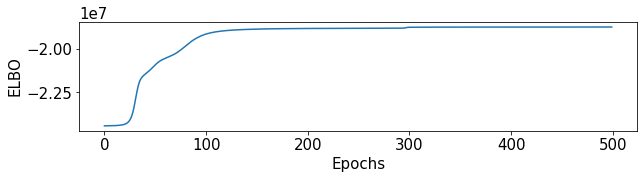

In [13]:
plot_elbo(elbo)

Text(0, 0.5, '$P(r_{\\mathrm{week}} = 1 | \\mathrm{week})$')

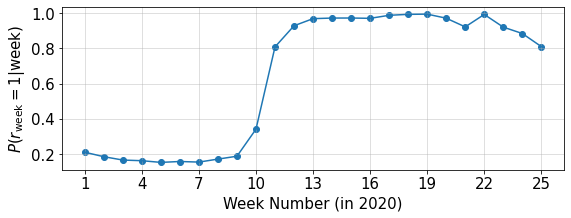

In [18]:
P_W_R = G.sum(axis=axis_except(0, 5)) * K_week
P_W_R /= P_W_R.sum(axis=1, keepdims=True)

plt.figure(figsize=(9,3))
plt.plot(P_W_R[:, 0])
plt.scatter(range(len(P_W_R[:, 0])), P_W_R[:, 0])
plt.xlabel("Week Number (in 2020)")
plt.xlabel("Week Number (in 2020)")
plt.xticks(range(0,26,3), [i+1 for i in range(0,26,3)])
plt.grid(alpha=0.5)
plt.ylabel(r"$P(r_{\mathrm{week}} = 1 | \mathrm{week})$")

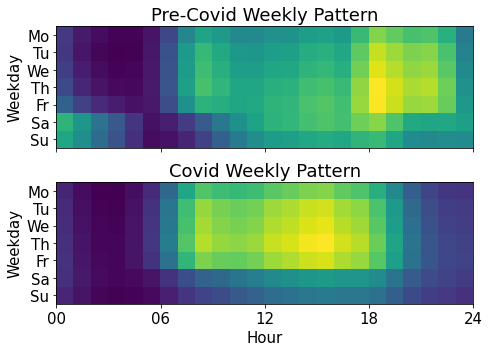

In [26]:
G_precovid = G[0]/G[0].sum()
G_covid = G[1]/G[1].sum()

P_precovid_time = jnp.einsum("de, ld, me -> lm", G_precovid.sum(axis=[0,1]), M_day, M_hour)
P_covid_time = jnp.einsum("de, ld, me -> lm", G_covid.sum(axis=[0,1]), M_day, M_hour)

fig, axes = plt.subplots(2,1,figsize=(15,5), sharex=True)

axes[1].set_xlabel("Hour")
axes[0].set_ylabel("Weekday")
axes[0].set_xticks([-0.5, 5.5, 11.5, 17.5, 23.5]); axes[0].set_xticklabels(["00", "06", "12", "18", "24"])
axes[0].set_yticks(range(7)); axes[0].set_yticklabels(["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"])
axes[1].set_yticks(range(7)); axes[1].set_yticklabels(["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"])
axes[1].set_ylabel("Weekday")
axes[0].set_title("Pre-Covid Weekly Pattern")#P(day, hour|r_{\mathrm{week}}=0)$")
axes[1].set_title("Covid Weekly Pattern")#("$P(day, hour|r_{\mathrm{week}}=1)$")
axes[0].imshow(P_covid_time)
axes[1].imshow(P_precovid_time)
fig.tight_layout()

In [31]:
from itertools import product

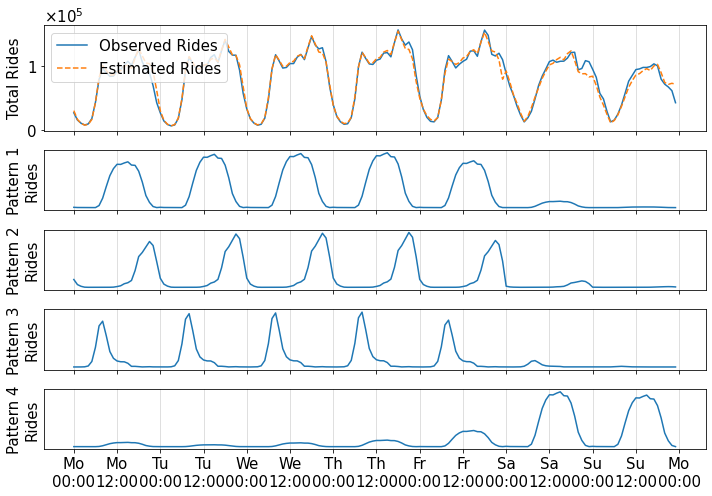

In [35]:
PR = jnp.einsum("abcde, ia, jb, kc, ld, me -> delm", G, K_week[:9], I_origin, I_destination, M_day, M_hour)
fig, axes = plt.subplots(5,1,sharex=True,gridspec_kw={"height_ratios":[1.75,1,1,1,1]}, figsize=(10,7))
observed_weekly_rides = np.load("data/nyc_yt/nyc_yt_weekly_rides_precovid.npy")

axes[0].plot(observed_weekly_rides,label="Observed Rides")
axes[0].plot(PR.sum(axis=(0,1)).flatten()*lam, linestyle="--",label="Estimated Rides")
axes[0].legend(loc="upper left")
axes[0].set_ylabel("Total Rides")
axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
axes[1].plot(PR[0, 1].flatten()*lam)
axes[1].set_ylabel("Pattern 1\nRides")
axes[2].plot(PR[0, 3].flatten()*lam)
axes[2].set_ylabel("Pattern 2\nRides")
axes[3].plot(PR[0, 4].flatten()*lam)
axes[3].set_ylabel("Pattern 3\nRides")
axes[4].plot(PR[1, 1].flatten()*lam)
axes[4].set_ylabel("Pattern 4\nRides")
axes[4].set_xticks([i for i in range(7*24) if i % 12 == 0] + [7*24])
axes[4].set_xticklabels([t[0] + t[1] + t[2] for t in product(["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"],["\n"],["00:00", "12:00"])] + ["Mo\n00:00"]);

for i in range(1,5):
  axes[i].set_yticks([])
for i in range(5):
  axes[i].grid(axis="x", alpha=0.5)
fig.tight_layout()

## Training BLRHS

We present a training run with a version of the data that includes 20 busiest tracts (see below for the full list of tracts). In the full BART dataset we have a tensor of size $25\times 265\times 265\times 7\times 24$. In the 10 location version loaded below, this is $25\times 265\times 265\times 7\times 24$. You can download the full data tensor at this link: https://drive.google.com/file/d/1Oa5F8WW9NnH-3ygc6cNs5u2yRFp-37Ao/view?usp=sharing, which you can use with the methods below. Note that the variable orders in the data are slightly different than in the paper, with no implications to the methodology and results.

### Recommendations when training with very large data
When training with very large tensors, the memory required by the computations might exceed the memory available, especially when training with BLRHS-T. If you encounter this problem, here are our suggestions:
- Prefer `cp_vb_batch`, `tucker_vb_batch` instead of `cp_vb`, `tucker_vb`, and increase num_batches parameter as needed. Batch versions are implemented specifically for this purpose.
- Force JAX to use CPU instead of GPU, which would use the computer RAM instead of GPU RAM, at the cost of a slow down. The command for this is: `import os; os.environ["JAX_PLATFORM_NAME"] = "cpu"`

In [47]:
# The tracts included in the subset: 
# tract_idx = [235, 236, 160, 161, 229, 169, 185, 141, 47, 233, 238, 140, 162, 67, 237, 78, 106, 139, 262, 163]
f = gzip.GzipFile("data/nyc_yt/nyc_yt_20_locations.npy.gz", "r")
X = np.load(file=f)
f.close()

### Example run with BLRHS-Tucker:

In [48]:
print_freq = 100 # Set to 0 if non-verbose training is desired.
a = 1000.0
R = [2, 2, 2, 2, 4]
seed = 0
num_epochs = 500
elbo, log_Ms = tucker_vb_batch(X, R=R, a=a, num_epochs=num_epochs, print_freq=print_freq, num_batches=5, seed=seed)

Epoch: 100, ELBO: -3110161
Epoch: 200, ELBO: -3000861
Epoch: 300, ELBO: -2995041
Epoch: 400, ELBO: -2993552
Epoch: 500, ELBO: -2992897


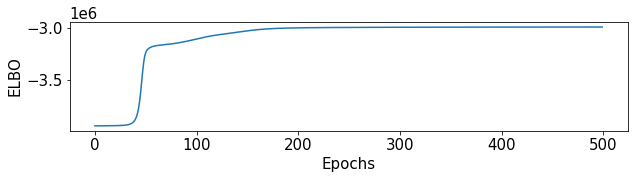

In [49]:
plot_elbo(elbo)

In [52]:
lam, G, K_week, I_origin, I_destination, M_day, M_hour = [jnp.exp(log_M) for log_M in log_Ms]
# The core tensor (normalizing to ensure interpretability as probability table).
G = G / G.sum()
# Factor matrices (normalizing to ensure interpretability as conditional probability tables).
K_week, I_origin, I_destination, M_day, M_hour = [
    arr/arr.sum(0, keepdims=True) for arr in [K_week, I_origin, I_destination, M_day, M_hour]
    ]

Text(0, 0.5, '$P(r_{\\mathrm{week}} = 1 | \\mathrm{week})$')

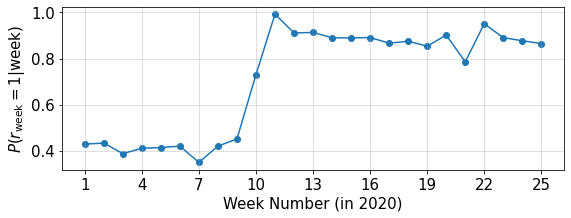

In [53]:
P_W_R = G.sum(axis=axis_except(0, 5)) * K_week
P_W_R /= P_W_R.sum(axis=1, keepdims=True)

plt.figure(figsize=(9,3))
plt.plot(P_W_R[:, 0])
plt.scatter(range(len(P_W_R[:, 0])), P_W_R[:, 0])
plt.xlabel("Week Number (in 2020)")
plt.xlabel("Week Number (in 2020)")
plt.xticks(range(0,26,3), [i+1 for i in range(0,26,3)])
plt.grid(alpha=0.5)
plt.ylabel(r"$P(r_{\mathrm{week}} = 1 | \mathrm{week})$")

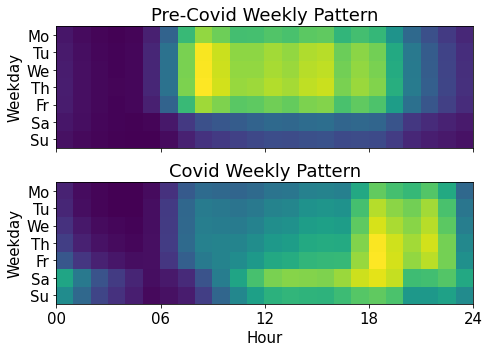

In [55]:
G_precovid = G[1]/G[1].sum()
G_covid = G[0]/G[0].sum()

P_precovid_time = jnp.einsum("de, ld, me -> lm", G_precovid.sum(axis=[0,1]), M_day, M_hour)
P_covid_time = jnp.einsum("de, ld, me -> lm", G_covid.sum(axis=[0,1]), M_day, M_hour)

fig, axes = plt.subplots(2,1,figsize=(15,5), sharex=True)

axes[1].set_xlabel("Hour")
axes[0].set_ylabel("Weekday")
axes[0].set_xticks([-0.5, 5.5, 11.5, 17.5, 23.5]); axes[0].set_xticklabels(["00", "06", "12", "18", "24"])
axes[0].set_yticks(range(7)); axes[0].set_yticklabels(["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"])
axes[1].set_yticks(range(7)); axes[1].set_yticklabels(["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"])
axes[1].set_ylabel("Weekday")
axes[0].set_title("Pre-Covid Weekly Pattern")#P(day, hour|r_{\mathrm{week}}=0)$")
axes[1].set_title("Covid Weekly Pattern")#("$P(day, hour|r_{\mathrm{week}}=1)$")
axes[0].imshow(P_covid_time)
axes[1].imshow(P_precovid_time)
fig.tight_layout()

### Example run with BLRHS-CP

In [56]:
print_freq = 100 # Set to 0 if non-verbose training is desired.
a = 1000.0
R = 20
seed = 0
num_epochs = 500
elbo, log_Ms = cp_vb(X, R=R, a=a, num_epochs=num_epochs, print_freq=print_freq, seed=seed)

Epoch: 100, ELBO: -2177161
Epoch: 200, ELBO: -2165201
Epoch: 300, ELBO: -2158615
Epoch: 400, ELBO: -2152144
Epoch: 500, ELBO: -2150654


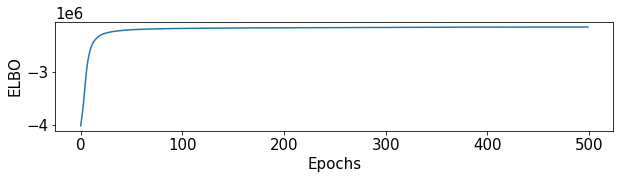

In [57]:
plot_elbo(elbo)

In [58]:
lam, G, K_week, I_origin, I_destination, M_day, M_hour = [jnp.exp(log_M) for log_M in log_Ms]
# The core tensor (normalizing to ensure interpretability as probability table).
G = G / G.sum()
# Factor matrices (normalizing to ensure interpretability as conditional probability tables).
K_week, I_origin, I_destination, M_day, M_hour = [
    arr/arr.sum(0, keepdims=True) for arr in [K_week, I_origin, I_destination, M_day, M_hour]
    ]

/home/melih/anaconda3/envs/thesis/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3870: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


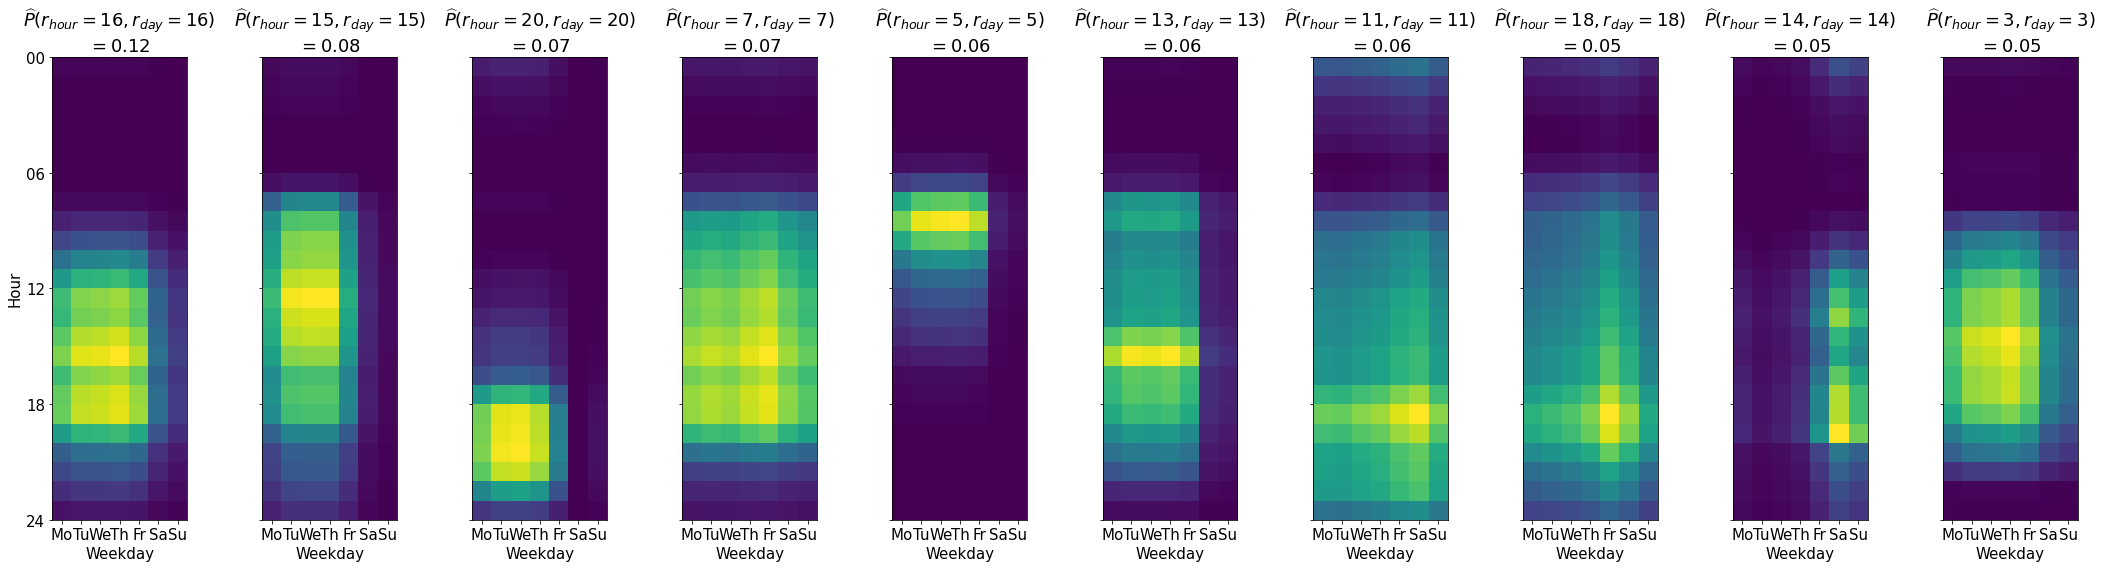

In [59]:
P_GDH = jnp.einsum("a, ia, ja -> aij", G, M_day, M_hour) # Notice the difference of the einsum compared to Tucker decomposition.
idxs, values = np.flip(np.argsort(G)), np.flip(np.sort(G))
num_patterns = 10
plot_weekly_patterns(P_GDH, idxs[:num_patterns, np.newaxis], values[:num_patterns], figsize=(8,7))